Goal: create maps of street networks, but only within a buffer around a geocoded place.

Next goal: functions to measure and visualize urban indicators.

Steps:
- write code to plot heatmap of point density [DONE]
- convert heatmap code to function [DONE]
- write code to clip heatmap to buffer ring [DONE]
- write code to get osm amenity data based on category

Ideas for Urban Indicators:
- intersection density (hexbin/heatmap) [DONE]
- density of x-height buildings (hexbin/heatmap)
- density of x kind of amenity (hexbin/heatmap)
    - sustenance (restaurants, bars, etc.)
    - education (school, college, university, etc.)
    - healthcare (clinic, hospital, etc.)
    - public service (fire station, town hall, police, etc.)
- isochrone from geocoded point

In [1]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [2]:
# PLACE_NAMES = [
#     # "Marikina, Metro Manila",
#     # "Quezon City, Metro Manila",
#     # "Manila, Metro Manila",
#     "Pasig, Metro Manila",
#     # "Taguig, Metro Manila"
# ]

In [3]:
# Set name for Nominatim query
query = "Concepcion Uno"
buffer_dist = 1_500

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

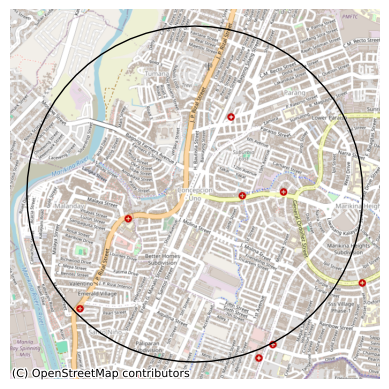

In [4]:
# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

In [5]:
# Get road network within buffer
graph = ox.graph_from_polygon(
    buffer.geometry[0],
    network_type="all_private",
    retain_all=True
)

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [6]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [7]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([2, 1, 4])

Examining the street intersections GDF

In [8]:
streets.head()

osmid  oneway  lanes                      name  \
u        v          key                                                       
21322197 32284894   0      4357068    True      2    Eraño G. Manalo Street   
         33118939   0      4989944   False      2  F. Alfelor Senior Street   
         26546377   0    261332447   False      2           Aquilina Street   
21322208 9241015605 0      4910296   False      2        J. P. Rizal Street   
         21322209   0    292500295   False      1              Haiti Street   

                             highway maxspeed reversed   length width  \
u        v          key                                                 
21322197 32284894   0       tertiary       40    False  264.153   NaN   
         33118939   0       tertiary      NaN     True   53.423   NaN   
         26546377   0       tertiary      NaN     True   86.098   NaN   
21322208 9241015605 0        primary       50    False  107.097     9   
         21322209   0    residential      NaN    False   58.997   NaN   

                                                                  geometry  \
u        v          key                                                      
21322197 32284894   0    LINESTRING (13480761.292 1648028.435, 13480647...   
         33118939   0    LINESTRING (13480761.292 1648028.435, 13480711...   
         26546377   0    LINESTRING (13480761.292 1648028.435, 13480841...   
21322208 9241015605 0    LINESTRING (13481334.220 1650059.018, 13481287...   
         21322209   0    LINESTRING (13481334.220 1650059.018, 13481389...   

                        bridge service junction access  
u        v          key                                 
21322197 32284894   0      NaN     NaN      NaN    NaN  
         33118939   0      NaN     NaN      NaN    NaN  
         26546377   0      NaN     NaN      NaN    NaN  
21322208 9241015605 0      NaN     NaN      NaN    NaN  
         21322209   0      NaN     NaN      NaN    NaN

In [9]:
intersections.head()

,y,x,street_count,highway,geometry
osmid,,,,,
21322197,14.642454,121.099739,4,NaN,POINT (13480761.292 1648028.435)
21322208,14.660102,121.104886,3,NaN,POINT (13481334.220 1650059.018)
21322209,14.659875,121.105381,4,NaN,POINT (13481389.368 1650032.829)
21322211,14.663038,121.106192,3,NaN,POINT (13481479.648 1650396.784)
25004295,14.651593,121.113376,3,NaN,POINT (13482279.345 1649079.876)


Plotting the street network and intersection heatmap

In [10]:
# plt.rcParams['figure.facecolor']='black'
# plt.rcParams['savefig.facecolor']='black'

In [11]:
# bounds = buffer.to_crs("EPSG:3857").total_bounds

# fig, ax = plt.subplots(figsize=(10,10))

# fig.suptitle(
#     "Road Network",
#     y=0.09,
#     x=0.5,
#     color="white",
#     fontsize=45.0,
#     fontfamily="Garamond",
#     # transform=fig.transFigure
# )

# streets.plot(
#     color="gold",
#     lw=0.25,
#     ax=ax
# )

# buffer.to_crs("EPSG:3857").plot(
#     facecolor="none",
#     edgecolor="gold",
#     lw=0.5,
#     ax=ax
# )

# ax.hist2d(
#     intersections.geometry.x,
#     intersections.geometry.y,
#     bins=50,
#     range=np.array([(bounds[0],bounds[2]),(bounds[1],bounds[-1])]),
#     weights=intersections.street_count,
#     cmin=1.0,
#     cmap="plasma",
#     vmin=1
# )

# plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95)

# ax.set_axis_off()

# plt.margins(1)

# # fig.set_facecolor("black")
# # fig.set_edgecolor("black")

d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)


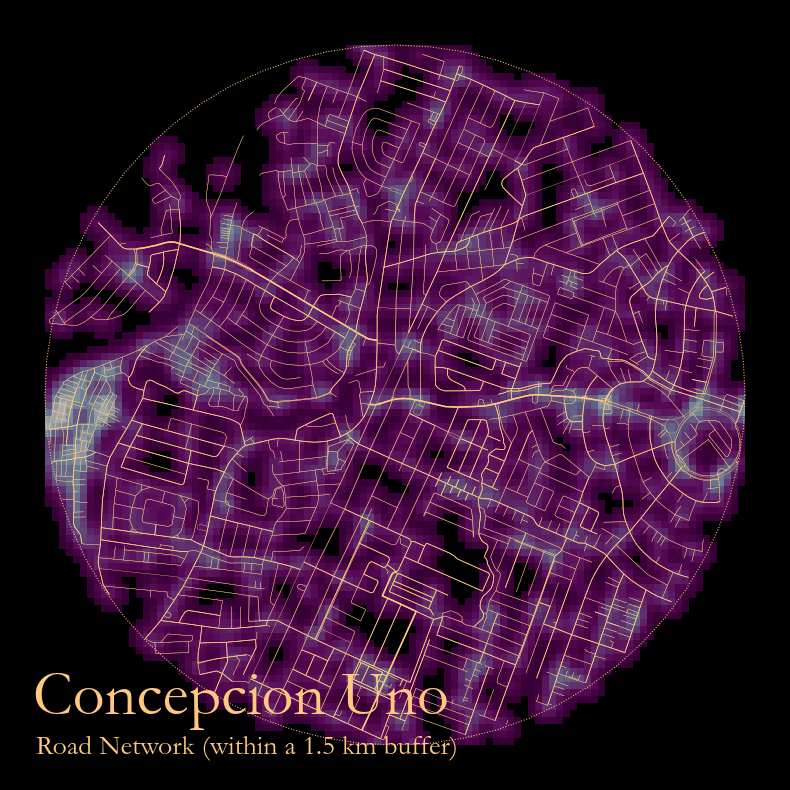

In [12]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

# print(f"axes x-limits:{ax.get_xlim()}\nbounds: {ring_bounds}")

# plt.hist2d(
#     intersections.geometry.x,
#     intersections.geometry.y,
#     bins=50,
#     range=[list(ring_bounds[0:2]), list(ring_bounds[2:])],
#     weights=intersections.street_count,
#     cmin=1.0,
#     cmap="plasma",
#     vmin=1
# )

plot_heatmap(
    intersections,
    "street_count",
    ax=ax,
    alpha=0.7,
    color_scheme="BuPu_r",
    bounds=ring_bounds
)

In [13]:
shop_pois = ox.features_from_polygon(
    buffer.geometry[0],
    {
        "shop": True,
        # "amenity": ["fast_food", "restaurant", "cafe"]
    }
)

shop_pois.shape

(305, 64)

In [14]:
# Import drop_nan_cols function we created
from urban_indicators_scripts import drop_nan_cols, filter_elem_type

# Apply imported function
# Parameters: gdf, max % of rows that are NaNs
shop_pois = drop_nan_cols(shop_pois, 0.75)

In [15]:
shop_pois.shape

(305, 5)

In [16]:
shop_pois = shop_pois.reset_index()
shop_pois.head()

,element_type,osmid,addr:city,addr:street,shop,geometry,name
0,node,307906742,Marikina,Bayan-Bayanan Avenue,bakery,POINT (121.11098 14.65088),NaN
1,node,325136789,NaN,NaN,bakery,POINT (121.11407 14.64453),Pan de Amerikana
2,node,748188323,Marikina,General B. G. Molina Street,supermarket,POINT (121.11267 14.65921),Ever Supermarket
3,node,757707271,Marikina,J.P. Rizal Street,pawnbroker,POINT (121.09771 14.64873),Cebuana Lhuillier
4,node,757707297,Marikina,J.P. Rizal Street,pawnbroker,POINT (121.09767 14.64868),Santolan Pawnshop


In [17]:
shop_pois["weight"] = 1.0

In [18]:
shop_pois = shop_pois.to_crs("EPSG:3857")

In [19]:
shop_pois["geometry"] = shop_pois["geometry"].centroid
shop_pois.shape

(305, 8)

d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


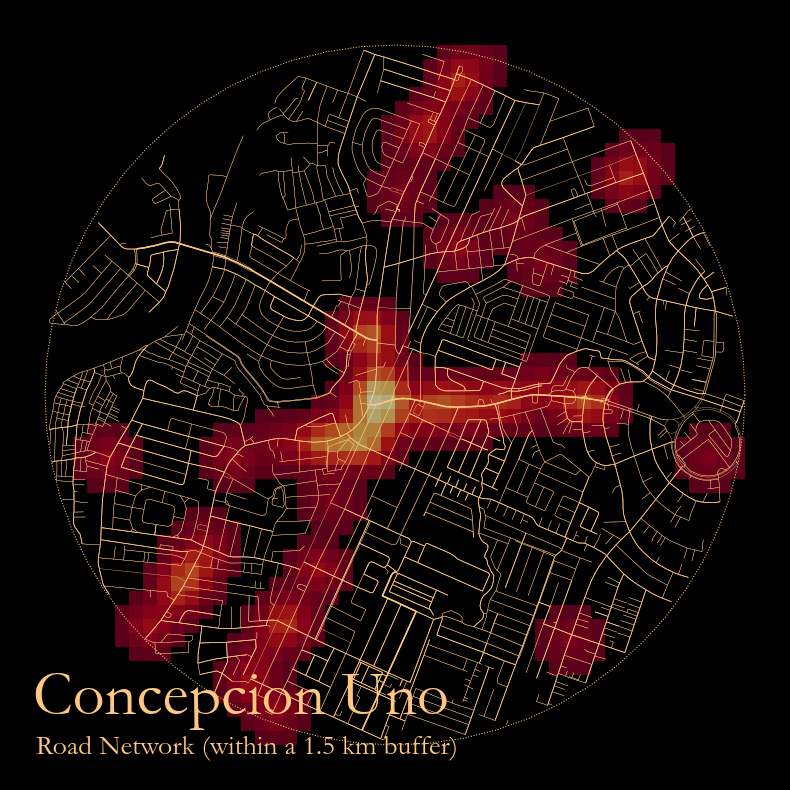

In [24]:
fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

# plt.hist2d(
#     shop_pois.geometry.x,
#     shop_pois.geometry.y,
#     bins=50,
#     range=[list(ring_bounds[0:2]), list(ring_bounds[2:])],
#     cmin=0.01,
#     cmap="plasma",
#     vmin=1
# )

plot_heatmap(
    shop_pois,
    "weight",
    bins=50,
    ax=ax,
    alpha=0.7,
    color_scheme="YlOrRd_r",
    bounds=ring_bounds
)